Тестовая задача для стажера - CV chess games analyze.
Среда выполнения: Google Colab

In [ ]:
# 1. Импортирование бибилиотек
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import accuracy_score
import torch.backends.cudnn as cudnn
from scipy import optimize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

# Монтируем Google Диск для доступа к файлам
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 2. Чтение файлов, анализ данных

# Чтение файлов
train = pd.read_csv('/content/gdrive/MyDrive/Тестовое задание (шахматы)/fens_training_set.csv')

train.head(100) #проверка корректности показа данных
#train.shape #проверка размерности данных

df = pd.DataFrame(train) #разделение данных
move_full_train = df['move'] #выделение одного столбца (move)
move_set = set(move_full_train) #получение уникальных значений
sorted_moves = sorted(move_set)

In [ ]:
# 3. Подготовка данных

#преобразование для FEN
def fen_to_matrix(fen_str):
    parts = fen_str.split()
    board_part = parts[0] #выделение строки положения
    active_color = parts[1] #разделение цветов
    castling = parts[2]        # Возможности рокировки
    en_passant = parts[3]      # Поле для взятия на проходе
    halfmove_clock = parts[4]  # Счётчик полуходов
    fullmove_number = parts[5] # Номер хода


    rows = board_part.split('/')
    board = np.zeros((8, 8, 12), dtype=np.int8)

    piece_to_index = {
        'K': 0, 'Q': 1, 'R': 2, 'B': 3, 'N': 4, 'P': 5,
        'k': 6, 'q': 7, 'r': 8, 'b': 9, 'n': 10, 'p': 11
    }

    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)  # пропускаем пустые клетки
            else:
                board[i, col, piece_to_index[char]] = 1
                col += 1

    #Извлчение признаков
    color_feature = 1 if parts[1] == 'w' else 0 #признак цвета фигуры

    castling_features = np.zeros(4)
    castling_to_index = {
    'K': 0,  # белые королевские
    'Q': 1,  # белые ферзевые
    'k': 2,  # черные королевские
    'q': 3   # черные ферзевые
}
    for char in parts[2]:
        if char in castling_to_index:
            castling_features[castling_to_index[char]] = 1

    en_passant_feature = 1 if parts[3] != '-' else 0 #признак прохода
    minor_feature = 1 if int(parts[4]) == 0 else 0 #признак незначащего хода
    move_feature = 1 if int(parts[5]) == 1 else 0 # признак порядка хода


    return board, [color_feature] + castling_features.tolist() + [en_passant_feature,minor_feature,move_feature]

train['fen_parsed'] = train['fen'].apply(fen_to_matrix)


In [ ]:
#преобразование для ходов
move_to_idx = {} # Создаем пустой словарь
number = 0 # начальный индекс

for i in sorted_moves:
    move_to_idx[i] = number # Добавляем ключ (ход) и значение (индекс)
    number = number+1

idx_to_move = {} #Создание второго словария в значение индекс-ход
for key, value in move_to_idx.items():
    idx_to_move[value] = key

train['move_label'] = train['move'].map(move_to_idx) # сопоставление индекса с
#train['move_label'].isna().sum()
#train.head(100)

In [ ]:
# Объединение признаков и матриц
def prepare_features(fen_str):
    # Получаем кортеж (матрица, признаки) из существующей функции
    matrix, additional_features = fen_to_matrix(fen_str)

    # Преобразуем матрицу 8x8x12 в плоский вектор
    flattened_matrix = matrix.reshape(-1)

    # Объединяем с дополнительными признаками
    combined_features = np.concatenate([flattened_matrix, additional_features])

    return combined_features

train['features'] = train['fen'].apply(prepare_features)
#train.head(100)

In [ ]:
# 4. Разделение данных и создание тензоров

#Разделение данных для обучения и проверки
Train, Val = train_test_split(train, test_size=0.2, random_state=42)

fen_train, move_train  = np.array(Train['features'].tolist(), dtype=np.float32), np.array(Train['move_label'], dtype=np.int64) #тренировочные данные
fen_val, move_val  = np.array(Val['features'].tolist(), dtype=np.float32), np.array(Val['move_label'], dtype=np.int64) #валидационные данные

fen_train_tensor,move_train_tensor  = torch.tensor(fen_train), torch.tensor(move_train) #тензор тренировочных данных
fen_val_tensor,move_val_tensor  = torch.tensor(fen_val), torch.tensor(move_val) #тензор валидационных данных


Epoch 1/40 | Train Loss: 5.6537 | Val Loss: 4.8600 | 
Epoch 2/40 | Train Loss: 4.7841 | Val Loss: 4.2398 | 
Epoch 3/40 | Train Loss: 4.4125 | Val Loss: 4.0143 | 
Epoch 4/40 | Train Loss: 4.2348 | Val Loss: 3.8633 | 
Epoch 5/40 | Train Loss: 4.1321 | Val Loss: 3.8114 | 
Epoch 6/40 | Train Loss: 4.0651 | Val Loss: 3.7538 | 
Epoch 7/40 | Train Loss: 4.0082 | Val Loss: 3.7211 | 
Epoch 8/40 | Train Loss: 3.9638 | Val Loss: 3.6703 | 
Epoch 9/40 | Train Loss: 3.9285 | Val Loss: 3.6444 | 
Epoch 10/40 | Train Loss: 3.9008 | Val Loss: 3.6340 | 
Epoch 11/40 | Train Loss: 3.8732 | Val Loss: 3.6161 | 
Epoch 12/40 | Train Loss: 3.8472 | Val Loss: 3.5961 | 
Epoch 13/40 | Train Loss: 3.8207 | Val Loss: 3.5725 | 
Epoch 14/40 | Train Loss: 3.7983 | Val Loss: 3.5726 | 
Epoch 15/40 | Train Loss: 3.7830 | Val Loss: 3.5489 | 
Epoch 16/40 | Train Loss: 3.7695 | Val Loss: 3.5517 | 
Epoch 17/40 | Train Loss: 3.7493 | Val Loss: 3.5304 | 
Epoch 18/40 | Train Loss: 3.7430 | Val Loss: 3.5234 | 
Epoch 19/40 | Train

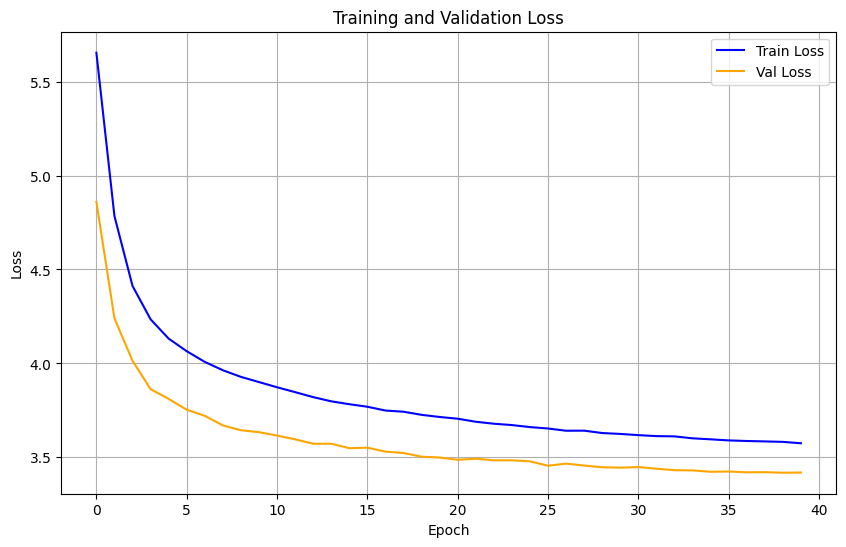

[('c2c3', 0.3534417450428009), ('e1g1', 0.32412007451057434), ('b1c3', 0.22384876012802124), ('b1d2', 0.03410559892654419), ('a2a3', 0.017011083662509918)]


In [ ]:
# 5. Создание датасетов и неросети ===

train_dataset = TensorDataset(fen_train_tensor, move_train_tensor) #Объединение тензоров в один датасет
val_dataset = TensorDataset(fen_val_tensor, move_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #итератор по мини-батчам
val_loader = DataLoader(val_dataset, batch_size=64)


# 5.1 Модель

class ChessMoveNet(nn.Module):
    def __init__(self, input_size, num_moves):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_moves)
        )

    def forward(self, x):
        return self.net(x)  # просто прогоняем через Sequential


# 5.2 Инициализация модели, оптимизатора и функции потерь

input_size = fen_train_tensor.shape[1] #определяется размер входного вектора
num_moves = len(move_to_idx)

model = ChessMoveNet(input_size, num_moves)

criterion = nn.CrossEntropyLoss() #задаём функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# (опционально: если есть GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Включить оптимизации CUDA
cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

# 5.3 Цикл обучения
val_losses = []

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad() #обнуляем градиенты от предыдущей итерации.
        outputs = model(X_batch) #получаем предсказания
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Проверка на валидации
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1) #выбираем класс с наибольшей вероятностью
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | ")


# Графики
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 5.4 Функция предсказания хода

def predict_move(fen_str):
    model.eval()
    features = prepare_features(fen_str) #превращает шахматную позицию FEN в числовой вектор
    x = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad(): #отключаем градиенты для экономии памяти.
        logits = model(x)
        probs = torch.softmax(logits, dim=1) #получаем вероятности для всех ходов
        top_probs, top_idxs = torch.topk(probs, 5)
        top_moves = [idx_to_move[i.item()] for i in top_idxs[0]]
        top_probs = top_probs[0].tolist() #выбор лучших ходов
    return list(zip(top_moves, top_probs))


# Использования

sample_fen = "r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/3P1N2/PPP2PPP/RNBQK2R w KQkq - 4 6"
print(predict_move(sample_fen))

In [ ]:
# 6. Метрики

accuracy = accuracy_score(y_batch.cpu().numpy(), preds.cpu().numpy())
precision = metrics.precision_score(y_batch.cpu().numpy(), preds.cpu().numpy(),average='macro')
recall = metrics.recall_score(y_batch.cpu().numpy(), preds.cpu().numpy(), average='micro')

print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

Accuracy: 0.2857142857142857
precision: 0.16666666666666666
recall: 0.2857142857142857


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Метрика top k
def top_k_accuracy(y_true, y_pred_probs, k=5):
    top_k = np.argsort(y_pred_probs, axis=1)[:, -k:]
    return np.mean([y_true[i] in top_k[i] for i in range(len(y_true))])

y_pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
top5_acc = top_k_accuracy(y_batch.cpu().numpy(), y_pred_probs, k=5)
print("Top-5 Accuracy:", top5_acc)

Top-5 Accuracy: 0.5
